In [1]:
from xml.dom import minidom
import re
import pandas as pd
import sys
import pickle
import numpy as np


from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()



sys.__stdout__=sys.stdout
def remove_tags(doc):
    text=doc.lower()
    #text=re.sub('\n',' ',text)
    #text=re.sub('-',' ',text)
    #text=re.sub('[()?.@*#&!,$]','',text)
    #text=re.sub('[\']','',text)
    #text=re.sub('[^a-z0-9]',' ',text)
    #words=doc.split(' ')
    text=re.sub('<[^<>]+>',' ',text)
    words=re.findall('\w+',text)
    return words


def make_dictionary(topics,max_doc,root):
    index=0
    wordmap={}
    word_count=[]
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        docs = mydoc.getElementsByTagName('row')
        doc_count=0
        for doc in docs:
            if doc_count>=max_doc:
                break
            doc=doc.attributes['Body'].value
            if len(doc)<5:
                continue
            
            doc=doc.lower()
            words= remove_tags(doc)
            
            for word in words:
                #word=ps.stem(word)
                if word in s_words or len(word)<=1:
                    continue
                if word not in wordmap:
                    wordmap[word]=index
                    word_count.append(int(1))
                    index=index+1
                elif word in wordmap:
                    ind=wordmap[word]
                    word_count[ind]=int(word_count[ind])+1
            doc_count=doc_count+1
    return wordmap,word_count
def remove_minor_words(wordmap,word_count,min_occurance):
    words=list(wordmap.keys())
    freq=list(wordmap.values())
    word_df=pd.DataFrame(words,index=list(wordmap.values()),columns=['words'])
    word_df=word_df.sort_index()
    word_df['freq']=wc
    word_df=word_df.sort_values('freq',ascending=False)
    mask=word_df['freq']<=min_occurance
    word_df=word_df[mask]
    
    ss_words=(list(word_df['words']))
    print('initial length of wordmap :',len(wordmap))
    for word in ss_words:
        del wordmap[word]
    
    _wordmap={}
    ind=0
    for word in wordmap.keys():
        _wordmap[word]=ind
        ind+=1
    print('reduced length of wordmap :',len(_wordmap))
    return _wordmap

In [2]:
def vectorize_seq_nb(topics,max_doc,wordmap,root,doc_per_vect='all'):
    if doc_per_vect=='single':
        n_row=len(topics)*(max_doc)
    if doc_per_vect=='all':
        n_row=len(topics)
    vectors=np.zeros((n_row,len(wordmap)),dtype=np.float64)
    vct_label=[]
    row=0
    _V=len(wordmap)
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        docs = mydoc.getElementsByTagName('row')
        doc_count=0
        for doc in docs:
            if doc_count>=max_doc:
                break
            #vector = [0]*(len(wordmap)+2)
            doc=doc.attributes['Body'].value
            if len(doc)<5:
                continue
            words = remove_tags(doc)
            
            for word in words:
                #word=ps.stem(word)
                if word in wordmap:
                    ind=wordmap[word]
                    vectors[row,ind]=vectors[row,ind]+1
            doc_count=doc_count+1
            word_list.append(words)
            if doc_per_vect=='single':
                vct_label.append(topic)
                row=row+1
        if doc_per_vect=='all':
            vct_label.append(topic)
            #total=np.sum(vectors[row])
            #vectors[row]=(vectors[row]+alpha)/(total+alpha*_V)
            row=row+1
    return vectors,vct_label

In [3]:
root='Dataset/Training/'
root_test='Dataset/Test/'
f=open('Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')

#topics=['3d_Printer','Coffee','Arduino','Astronomy','Biology']#,'Chess','Cooking','Law','Space','Windows_Phone','Wood_Working']
#topics=['Anime']

topics=['3d_Printer','Arduino','Anime']
#topics=['3d_Printer','Coffee','Chess','Arduino','Law']
#topics=['3d_Printer','Anime','Arduino']
#topics=['3d_Printer','Coffee','Chess']
 
#wordmap=make_dictionary(topics,100,root)
#vectors=vectorize_seq(topics,100,wordmap,root)
word_list=[]
write_backup=1
max_docs_train=200
if write_backup==1:
    wordmap,wc=make_dictionary(topics,max_docs_train,root)
    print('Removing minor words:')
    #wordmap=remove_minor_words(wordmap,wc,1)
    print('Vectorizing Sequence:')
    vectors,vct_labels=vectorize_seq_nb(topics,max_docs_train,wordmap,root)
    pickle_out = open("wordmap_test.pickle","wb")
    pickle.dump(wordmap, pickle_out)
    pickle_out.close()
    pickle_out = open("vectors_test.pickle","wb")
    pickle.dump(vectors, pickle_out)
    pickle_out.close()

read_backup=0
if read_backup==1:
    print('Reading backup')
    pickle_read = open("wordmap_500.pickle","rb")
    wordmap=pickle.load(pickle_read)
    pickle_read.close()

    pickle_read = open("vectors_500.pickle","rb")
    vectors=pickle.load(pickle_read)
    pickle_read.close()

#words=list(wordmap.keys())
#freq=list(wordmap.values())
#word_df=pd.DataFrame({'words':words,'freq':freq})
#word_df=word_df.sort_values('freq',ascending=False)
    



3d_Printer
Arduino
Anime
Removing minor words:
Vectorizing Sequence:
3d_Printer
Arduino
Anime


In [4]:
print(len(wordmap))

7387


[35. 63. 16. ...  0.  0.  0.]


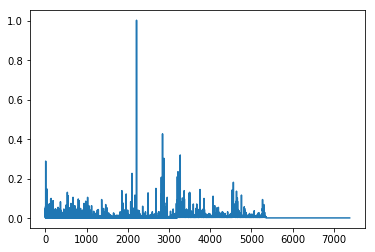

['3d_Printer', 'Arduino', 'Anime']
7387
0.0
0.002816901408450704


In [160]:
from matplotlib import pyplot as plt
print((vectors[0]))
x=range(len(vectors[0]))
alp=1
V=vectors.copy()
for i in range(len(V)):
    A=V[i]+alp
    B=(np.sum(vectors[0])+alp*np.sum(vectors))
    C=A/B
    V[i]=C
k=np.max(V)-np.min(V)
D[V==0]=1
D=V/k
#plt.plot(x,C)
plt.plot(x,D[1])
#plt.plot(x,vectors[2])
#plt.plot(x,vectors[2])
plt.show()
print(vct_labels)
print(len(wordmap))
print(np.prod(D[1]))
print(np.min(D))
#no stem 500 20599 
#stem 500 14883

In [181]:
max_docs_test=20
test_vectors,true_lbs=vectorize_seq_nb(topics,max_docs_test,wordmap,root_test,doc_per_vect='single')
def nb(test_vector,vectors,vct_labels,alpha):
    probs=[]
    maxm=0
    lb=''
    vct=0
    _vectors=vectors.copy()
    total_word_all=np.sum(_vectors)#len(wordmap)
    for row in range(len(_vectors)):
        total_word=np.sum(_vectors[row])
        _vectors[row]=np.array((_vectors[row]+alpha),dtype=np.float64)
        _vectors[row]=_vectors[row]/(total_word+alpha*total_word_all)
    #norm_value=(1000.0-0.0)/(np.max(_vectors)-np.min(vectors))
    for row in range(len(_vectors)):
        vect=_vectors[row].copy()
        #vect=vect*norm_value#1000#total_word_all#np.sum(_vectors)
        vect[test_vector==0]=1.0
        vect=np.float64(vect)
        #test_vector_zero_mask=np.array(test_vector==0,dtype=np.uint8)
        #test_vector_one_mask=np.array(test_vector!=0,dtype=np.uint8)
        #vect=test_vector_one_mask*vectors[row]+test_vector_zero_mask
        
        #print('vect',vect)
        #plt.plot(range(len(vect)),vect)
        #plt.show()
        #vect[vect<0.00001]=1
        prob=np.prod(vect)
        #prob=1
        #for p in range(len(vect)):
        #    if vect[p]!=1:
        #        prob*=(vect[p]*1000)
        #prob=np.sum(vect)
        probs.append(prob)
        if prob>=maxm:
            maxm=prob
            lb=vct_labels[row]
    return probs,lb
print(len(test_vectors[0]))

3d_Printer
Arduino
Anime
7387


In [182]:
import time
alph=10
no_topics=len(topics)
tot_doc=no_topics*max_docs_train
tot_doc_test=no_topics*max_docs_test
acc_log=''
acc_log+='******************************************************************\n'
acc_log+=str(topics)+'\n'
acc_log+=str(['no_topic','train doc per topic','train_doc','test doc per topic','test_doc','word map'])+'\n'
acc_log+=str([no_topics,max_docs_train,tot_doc,max_docs_test,tot_doc_test,str(len(wordmap))])+'\n'
acc_log+='******************************************************************\n'
acc_log+=str(['alpha','accuracy','time'])+'\n'
lst=np.array([1,5,10],dtype=np.float64)
alpha_list=np.concatenate((lst/10,lst/100,lst/1000,lst/10000,lst/100000))
alpha_list=np.round(alpha_list,5)
#alpha_list=[.1]
for al in alpha_list:
    T=time.time()
    acc=0
    alpha=al
    for i in range(len(test_vectors)):
        pred,pred_label=nb(test_vectors[i],vectors,vct_labels,alpha)
        #print(true_lbs[i],pred_label)
        #print(pred)
        if pred_label==true_lbs[i]:
            acc=acc+1
        else:
            #print('no')
            #print(pred)
            pass
        #print('res','pred',lb,'true',true_lbs[i],i+1,acc)
    T=time.time()-T
    accuracy=acc/(i+1)
    print('alpha: ',alpha,'acc :',accuracy)
    acc_log+=(str([alpha,accuracy,T])+'\n')
acc_log=re.sub('[\[\]]','',acc_log)
#f=open('Report/nb_topic3_200_20.csv','a')
#f.write(acc_log)
#f.close()
    #print(pred)

alpha:  0.1 acc : 0.8833333333333333
alpha:  0.5 acc : 0.8666666666666667
alpha:  1.0 acc : 0.85
alpha:  0.01 acc : 0.8666666666666667
alpha:  0.05 acc : 0.8833333333333333
alpha:  0.1 acc : 0.8833333333333333
alpha:  0.001 acc : 0.8666666666666667
alpha:  0.005 acc : 0.8666666666666667
alpha:  0.01 acc : 0.8666666666666667
alpha:  0.0001 acc : 0.85
alpha:  0.0005 acc : 0.8666666666666667
alpha:  0.001 acc : 0.8666666666666667
alpha:  1e-05 acc : 0.85
alpha:  5e-05 acc : 0.85
alpha:  0.0001 acc : 0.85


In [175]:
print(np.sum(vectors[0]))

10771.0


In [51]:
1.0e-325

0.0

In [15]:
#print(word_list)
d=np.array([1,2,3,4,5,6])
print(d)
k=d.copy()
k[k==3]=100
print(d,k)
tv=vectors
a=vectors[0,:]
#print(len())
print(np.array([k==2],dtype=np.uint8))
var=8
print(id(var))
def v(var):
    var=var+1
    print(id(var))
    return var
var=v(var)
print(id(var))
v=np.ones(5)
def func(v):
    v[2]=v[2]+1
    return 1
func(v)
print(v)

[1 2 3 4 5 6]
[1 2 3 4 5 6] [  1   2 100   4   5   6]
[[0 1 0 0 0 0]]
10910624
10910656
10910656
[1. 1. 2. 1. 1.]


In [16]:
words=list(wordmap.keys())
freq=list(wordmap.values())
word_df=pd.DataFrame(words,index=list(wordmap.values()))
word_df=word_df.sort_index()
word_df['freq']=wc
word_df=word_df.sort_values('freq',ascending=False)
print(word_df[0:50])
#print(len(vectors))

               0  freq
1323          li   790
4608        code   503
2441     arduino   463
26          http   459
25          href   439
404       strong   385
944           em   378
29           com   318
400          rel   232
10           use   230
441     nofollow   224
54         print   196
718   blockquote   194
13          like   184
3364       anime   181
1417          ul   174
3093       board   160
27           www   158
55          time   138
89         using   135
64          used   135
34      printing   128
3035         pre   121
15            3d   120
711         just   119
5892      serial   117
586          way   113
437           en   111
98      filament   111
3062       power   108
3125         pin   107
16       printer   106
41          need   103
3455       manga   101
3379          gt    98
155         make    97
3121        pins    95
222          org    92
195         does    92
439         wiki    88
3081          lt    87
3456      series    85
2331       

In [17]:
from matplotlib import pyplot as plt
vct=[vectors[12][:500]]
test=vectors[15][:498]
dis=eucl_dis(test,vct)
print(vct)
print(test)
print(dis[0][0])
x=range(0,500)
xt=range(0,498)
plt.plot(x,vct[0],xt,test)
plt.show

IndexError: index 12 is out of bounds for axis 0 with size 3

In [18]:
def eucl_dis(test_vector,vectors):
    h_dists=[]
    for vector in vectors:
        vect=np.array(vector[:-2])
        vect[vect>1]=1
        label=vector[-1]
        test_vect=np.array(test_vector)
        dist=np.abs(vect-test_vect)
        #dist=np.sum(dist)
        h_dists.append([dist,label])
    return h_dists

test_vector=vectors[0][:-2]
vecto=[vectors[0],vectors[1]]
h_dists=cos_dis(test_vector,vecto)
#h_df=pd.DataFrame(h_dists)
#h_df=h_df.sort_values(0)
print(h_dists)
#print((vectors[15]))

NameError: name 'cos_dis' is not defined

In [109]:
raw='I am hasib\n,i "am" a student() so? @i do& my-duties! porp. and' 
#text=re.sub('\n',' ',raw)
text=raw.lower()
text=re.sub('[^a-z0-9]',' ',text)
#text=re.sub('-',' ',text)
#text=re.sub('[\'"]','',text)
#text=re.sub('[()?.@*#&!,$+]','',text)
#print(text.split(' '))

In [27]:
txt=(str([1,2,3]))
txt=re.sub('[\[\]]','',txt)
print(txt)

1, 2, 3
